In [1]:
from keras import applications,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 

from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import Dropout, Flatten, Dense

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D

from keras_squeezenet import SqueezeNet

Using TensorFlow backend.


In [2]:
import shutil,os
import pandas as pd
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('sim-data-capture/sim_data_large.yaml', 'r') as f:
    df = pd.io.json.json_normalize(yaml.load(f))

def parse_values(val):

    if len(val) == 0:
        return 'noColor'
    else:
        return (val[0]['class'])
    
df['color'] = df.annotations.map(parse_values)
df.filename = df.filename.str.replace('sim_data_capture/','sim-data-capture/',)

In [4]:
shutil.rmtree('data/train/')
shutil.rmtree('data/valid/')
os.mkdir('data/train/')
os.mkdir('data/valid/')

os.mkdir('data/train/Green')
os.mkdir('data/train/Red')
os.mkdir('data/train/Yellow')
os.mkdir('data/train/noColor')

os.mkdir('data/valid/Green')
os.mkdir('data/valid/Red')
os.mkdir('data/valid/Yellow')
os.mkdir('data/valid/noColor')

for color in ['Green','Yellow','Red','noColor']:
    
    files = df[df.color == color].filename.values.tolist()
    if color == 'Red':
        np.random.shuffle(files)
        files = files[:55] #randomly select only 55 enteries
    print(color, len(files))
    for filename in files:
        if np.random.rand(1)[0] < 0.8:
            shutil.copy(src= filename, dst='data/train/'+color+'/')
        else:    
            shutil.copy(src= filename, dst='data/valid/'+color+'/')


Green 59
Yellow 44
Red 55
noColor 43


In [5]:
img_width, img_height = 227, 227
train_data_dir = "data/train"
validation_data_dir = "data/valid"
nb_train_samples = 208
nb_validation_samples = 48 
batch_size = 16
epochs = 100

In [6]:
#training data generator
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

In [7]:
#validation data generator
valid_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)


In [8]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

Found 166 images belonging to 4 classes.


In [9]:

validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
#batch_size = batch_size*0.40, 

class_mode = "categorical")

Found 35 images belonging to 4 classes.


In [24]:
classes = 4

model = SqueezeNet(include_top=False, pooling=None , input_shape=(227,227,3))
for layer in model.layers:
    #print(layer.trainable, end=',')
    layer.trainable = False

x = model.output
#reducing the size through convolutions so parameters stay reasonable
# x = Dropout(0.5, name='drop9')(x)
# x = Convolution2D(50, kernel_size=(3, 3), strides=(2,2), padding='valid', name='conv10')(x)
# x = Activation('relu', name='relu_conv10')(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.6)(x)
x = Dense(512, activation="relu")(x)
x = Dense(classes, activation="softmax")(x)



model_final = Model(inputs = model.input, outputs = x)
#optimizers.SGD(lr=0.00005) also gives decent results
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.00005, momentum=0.9), metrics=["accuracy"])


In [25]:
model_final.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792        input_3[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

In [16]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 75,# nb_train_samples/batch_size,
epochs = 200,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/200
75/75 [==============================] - 4s - loss: 2.8931 - acc: 0.2503 - val_loss: 1.3848 - val_acc: 0.2632
Epoch 2/200
75/75 [==============================] - 4s - loss: 1.4468 - acc: 0.2727 - val_loss: 1.3861 - val_acc: 0.2632
Epoch 3/200
75/75 [==============================] - 4s - loss: 1.4049 - acc: 0.2845 - val_loss: 1.3863 - val_acc: 0.2368
Epoch 4/200
75/75 [==============================] - 4s - loss: 1.4002 - acc: 0.2705 - val_loss: 1.3859 - val_acc: 0.2368
Epoch 5/200
75/75 [==============================] - 4s - loss: 1.3713 - acc: 0.3144 - val_loss: 1.3855 - val_acc: 0.2632
Epoch 6/200
75/75 [==============================] - 4s - loss: 1.3883 - acc: 0.2872 - val_loss: 1.3854 - val_acc: 0.2632
Epoch 7/200
75/75 [==============================] - 4s - loss: 1.3706 - acc: 0.3083 - val_loss: 1.3658 - val_acc: 0.3158
Epoch 8/200
75/75 [==============================] - 4s - loss: 1.3772 - acc: 0.2881 - val_loss: 1.3446 - val_acc: 0.5000
Epoch 9/200
75/75 [=====

75/75 [==============================] - 4s - loss: 0.1655 - acc: 0.9358 - val_loss: 0.2280 - val_acc: 0.8947
Epoch 134/200
75/75 [==============================] - 4s - loss: 0.1732 - acc: 0.9389 - val_loss: 0.1754 - val_acc: 0.8947
Epoch 135/200
75/75 [==============================] - 4s - loss: 0.1728 - acc: 0.9289 - val_loss: 0.1606 - val_acc: 0.9474
Epoch 136/200
75/75 [==============================] - 4s - loss: 0.1588 - acc: 0.9397 - val_loss: 0.1531 - val_acc: 0.9474
Epoch 137/200
75/75 [==============================] - 4s - loss: 0.1477 - acc: 0.9445 - val_loss: 0.1398 - val_acc: 0.8947
Epoch 138/200
75/75 [==============================] - 4s - loss: 0.1665 - acc: 0.9425 - val_loss: 0.1325 - val_acc: 0.9211
Epoch 139/200
75/75 [==============================] - 4s - loss: 0.1783 - acc: 0.9336 - val_loss: 0.1550 - val_acc: 0.9211
Epoch 140/200
75/75 [==============================] - 4s - loss: 0.1618 - acc: 0.9381 - val_loss: 0.1207 - val_acc: 0.9211
Epoch 141/200
75/75 [=

In [ ]:
#labels are [green, red, yellow, noColor]

### Correctly identifies as green with 0.99% 

32
[[  9.99732792e-01   1.41887140e-04   1.25208273e-04   6.04198220e-08]]


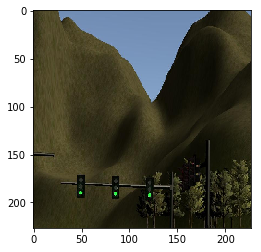

In [19]:
images, labels = next(validation_generator)

print(len(labels))

sample_index = 4
plt.figure()
plt.imshow(images[sample_index])
print(model_final.predict(np.array([images[sample_index]])))

### Correctly identifies as red with 0.99% 

[[  2.30311518e-04   9.99684334e-01   8.45303439e-05   7.42800125e-07]]


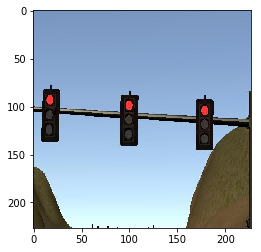

In [22]:
sample_index = 6
plt.figure()
plt.imshow(images[sample_index])
print(model_final.predict(np.array([images[sample_index]])))